In [1]:
### Load PPS model
%run ./PPS_model.ipynb

In [2]:
### Load experimental data (Di Cosmo et al., 2017)

HCdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='HC') 
SCZdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='SCZ') 
SPQdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='high spq') 
LSPQdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='low spq') 

sets = [HCdata,SCZdata,SPQdata,LSPQdata]
RTdata = []

for i in sets:
    subjects = i['Subject'].unique()
    delays = i[(i['Sound']=='Loom')&(i['Cond'] != 'Loom_NO')]['Cond'].unique()
    delays = np.delete(delays,np.where(delays=='Loom_-700')[0])
    idx = [3,4,0,1,2]
    delays = delays[idx]
    RTs = []
    
    for s in subjects:
        meanRTs = []
        for t in delays:
            RT = i[(i['Subject'] == s)&(i['Cond'] == t)]['Rtpul']           
            meanRTs.append(np.mean(RT))
        RTs.append(meanRTs)
    RTdata.append(RTs)
    
HC_RTs = np.asarray(RTdata[0])
SCZ_RTs = np.asarray(RTdata[1])
SPQ_RTs = np.asarray(RTdata[2])
LSPQ_RTs = np.asarray(RTdata[3])

In [3]:
### Audio-tactile experiment simulation setup 

## Calculate distance in cms. Speaker is positioned at 100cm from the hand. 
times = np.asarray([300,800,1500,2200,2700])
timesweep = np.arange(300,2800,100)
ts = timesweep/1000
v = 30 #cm/s 
a_distances = (120 - ts*v) # distance points in cm (network coordinates)

## Simulation setup
simtime = 200 #ms 

## Synapses setup
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) 
bi = 0
pr = 0

In [4]:
## Lateral inputs

# Tactile area
def myLIt(z,Lt): # z is a matrix of MtxNt dimensions
    LI = np.zeros(Mt*Nt)
    z = np.reshape(z,(1,Mt*Nt))
    for i in range(Mt*Nt):
            LI[i] = np.sum(np.multiply(Lt[i,:],z[0,:])) 
    LI = np.reshape(LI,(Mt,Nt))
    return LI
# Auditory area
def myLIa(z,La): # z is a matrix of MaxNa dimensions
    LI = np.zeros(Ma*Na)
    z = np.reshape(z,(1,Ma*Na))
    for i in range(Ma*Na):
            LI[i] = np.sum(np.multiply(La[i,:],z[0,:])) 
    LI = np.reshape(LI,(Ma,Na))
    return LI


## Experiment function
def myexperimentrun(a_distances,time,b,pr,Lex,Lin,Sex,Sin):
    Lt,La = Lw(Lex,Lin,Sex,Sin,Lex,Lin,Sex*20,Sin*20)
    
    dt = 0.4
    timesteps = int(time/dt)
    ndist = len(a_distances)
    
    RTs = np.zeros(ndist)
    ZTs = np.zeros((Mt,Nt,ndist))
    ZAs = np.zeros((Ma,Na,ndist))
    
    ti = PHIt(0) 
    PrBa = prun(Ba,pr)
    PrWa = prun(Wa,pr*2.6)
    dtau = dt/tau
    
    qt = np.zeros((Mt,Nt,timesteps+1,ndist))
    ut = np.zeros((Mt,Nt,timesteps+1,ndist))
    zt = np.zeros((Mt,Nt,timesteps+1,ndist))
    pt = np.zeros((Mt,Nt,timesteps+1,ndist))

    qa = np.zeros((Ma,Na,timesteps+1,ndist))
    ua = np.zeros((Ma,Na,timesteps+1,ndist))
    za = np.zeros((Ma,Na,timesteps+1,ndist))
    pa = np.zeros((Ma,Na,timesteps+1,ndist))

    qm = np.zeros((timesteps+1,ndist))
    um = np.zeros((timesteps+1,ndist))
    zm = np.zeros((timesteps+1,ndist))
    pm = np.zeros((timesteps+1,ndist))
    
    ZT = np.zeros((1,timesteps+1,ndist))
    
    for d in range(ndist):
        xa_0 = a_distances[d] # How far the sound is presented.     
        ai = PHIa(0,xa_0) # Generates an auditory input

        for i in range(timesteps):    
            # Tactile activity
            ut[:,:,i+1,d] = ti+myLIt(zt[:,:,i,d],Lt)+bt(zm[i,d])
            qt[:,:,i+1,d] = qt[:,:,i,d] + dtau*(-qt[:,:,i,d]+ut[:,:,i,d])
            pt[:,:,i+1,d] = psit(qt[:,:,i,d],b)
            zt[:,:,i+1,d] = pt[:,:,i,d]*np.heaviside(pt[:,:,i,d],0)

            ZT[0,i+1,d] = np.sum(zt[:,:,i,d])

            # Auditory activity
            ua[:,:,i+1,d] = ai+myLIa(za[:,:,i,d],La)+ba(zm[i,d],PrBa) 
            qa[:,:,i+1,d] = qa[:,:,i,d] + dtau*(-qa[:,:,i,d]+ua[:,:,i,d])
            pa[:,:,i+1,d] = psia(qa[:,:,i,d],b)
            za[:,:,i+1,d] = pa[:,:,i,d]*np.heaviside(pa[:,:,i,d],0)

            # Multisensory activity
            um[i+1,d] = np.sum(np.multiply(Wt,zt[:,:,i,d])) + np.sum(np.multiply(PrWa,za[:,:,i,d]))
            qm[i+1,d] = qm[i,d] + dtau*(-qm[i,d]+um[i,d])
            pm[i+1,d] = psim(qm[i,d])
            zm[i+1,d] = pm[i,d]*np.heaviside(pm[i,d],0)    
        RT = np.argmax(zt[19,9,:,d]>0.9)*dt
    
        RTs[d] = RT
        ZMs = zm        
        ZTs[:,:,d] = zt[:,:,timesteps,d]
        ZAs[:,:,d] = za[:,:,timesteps,d]   
    return RTs,ZMs,ZTs,ZAs


In [ ]:
idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
edata = np.mean(SCZ_RTs,axis=0)

def sczmodelrun(theta):
    sczRTs,ZMs,ZTs,ZAs = myexperimentrun(distances,simtime,bi,pr,theta[0],theta[1],theta[2],theta[3])
    yf = edata
    xf = sczRTs
    
    m = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
    bias = (np.sum(yf) - m*np.sum(xf)) / xf.size
    
    if bias<0: bias=0
    if m<0: m=0
    
    cost = np.sum(np.square(np.divide(yf-(m*xf+bias),yf)))
    
    return cost*100000

bounds=[(0,1.5),(0,2.95),(0.01,1.25),(0.01,10)]
res = differential_evolution(sczmodelrun,bounds,disp=True,strategy='rand1bin')
# Try with bounds 0 to 1.25. 

differential_evolution step 1: f(x)= 415.983
differential_evolution step 2: f(x)= 415.983
differential_evolution step 3: f(x)= 415.983
differential_evolution step 4: f(x)= 391.347
differential_evolution step 5: f(x)= 391.347
differential_evolution step 6: f(x)= 391.347
differential_evolution step 7: f(x)= 391.347
differential_evolution step 8: f(x)= 382.066
differential_evolution step 9: f(x)= 382.066
differential_evolution step 10: f(x)= 382.066
differential_evolution step 11: f(x)= 382.066
differential_evolution step 12: f(x)= 382.066
differential_evolution step 13: f(x)= 382.066
differential_evolution step 14: f(x)= 382.066
differential_evolution step 15: f(x)= 382.066
differential_evolution step 16: f(x)= 382.066
differential_evolution step 17: f(x)= 382.066
differential_evolution step 18: f(x)= 382.066
differential_evolution step 19: f(x)= 382.066
differential_evolution step 20: f(x)= 382.066
differential_evolution step 21: f(x)= 382.066
differential_evolution step 22: f(x)= 382.0

In [ ]:
print(res)

In [7]:
idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
sczRTs,ZMs,ZTs,ZAs = myexperimentrun(distances,simtime,0,0,1.3351804 , 0.4138984 , 0.52653547, 7.82810044)

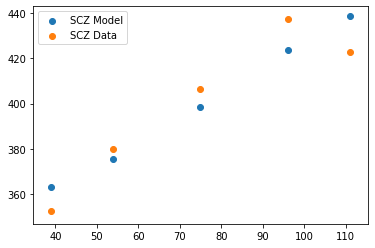

In [9]:
xf = sczRTs
yf = np.mean(SCZ_RTs,axis=0)    
m = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
bias = (np.sum(yf) - m*np.sum(xf)) / xf.size

if bias<0: bias=0
if m<0: m=0

plt.figure(1)
plt.scatter(distances,m*sczRTs+bias,label = 'SCZ Model')
plt.scatter(distances,yf,label = 'SCZ Data')
plt.legend()

In [10]:
sczres = np.asarray([m*xf+bias,yf])
np.save('sczrescopy2.npy', sczres)

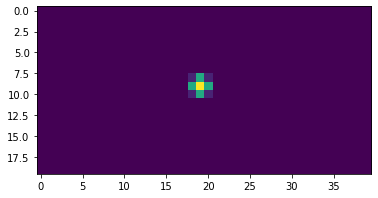

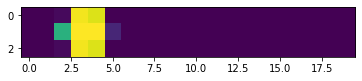

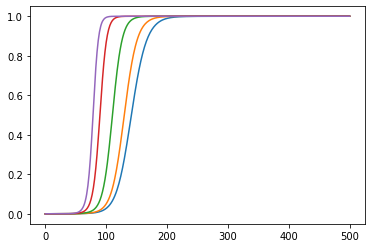

In [11]:
evdis = 4

plt.figure(2)
plt.imshow(ZTs[:,:,evdis].transpose());

plt.figure(3)
plt.imshow(ZAs[:,:,evdis].transpose());

plt.figure(4)
plt.plot(ZMs);

In [19]:
Lt,Lv = Lw(1.49474331,0.90056506,1.22327119,0.11224038,1.49474331,0.90056506,1.22327119*20,0.11224038*20)

NameError: name 'Lt' is not defined

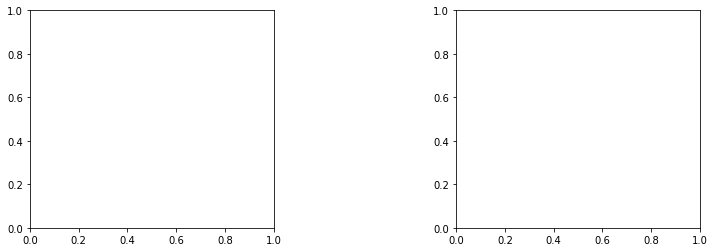

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(12,4));
fig.subplots_adjust(wspace = 0.75, hspace = 0.5)

ax1 = plt.subplot(121)
im1 = ax1.imshow(Lt)
ax1.set_xlabel('Neuron number',size=16)
ax1.set_ylabel('Neuron number',size=16)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = fig.colorbar(im1,cax=cax)
cbar.ax.get_yaxis().labelpad = 12
cbar.ax.set_ylabel('L\u1D57', rotation=270,size=18)
ax1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, 
            size=20, weight='bold')

ax2 = plt.subplot(122)
im2 = ax2.imshow(Lv)
plt.xlabel('Neuron number',size=16)
plt.ylabel('Neuron number',size=16)
#ax2.set_xticks(np.arange(-.5, 61, 10))
#ax2.set_yticks(np.arange(-.5, 61, 10))
#ax2.set_xticklabels(np.arange(0, 61, 10))
#ax2.set_yticklabels(np.arange(0, 61, 10))
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = fig.colorbar(im2,cax=cax)
cbar.ax.get_yaxis().labelpad = 12
cbar.ax.set_ylabel('L\u1D5B', rotation=270,size=18)
ax2.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax2.transAxes, 
            size=20, weight='bold')

fig.subplots_adjust(wspace=.25)

plt.savefig('sczrecsynapses.png', bbox_inches='tight')

In [13]:
print(sczRTs)
print(m,bias)

[67.2 64.8 60.8 57.2 55.2]
6.280055082200553 16.535467648218855
